In [1]:
from BSTools_pennylane import *
from matplotlib import pyplot as plt
from matplotlib import cm

In [15]:
# PDE parameters
sigma = 0.2
r = 0.3
Smax = 135
K = 50
T = 1

# Simulation parameters
n = 6 # Number of qubits
N = 2**n


instance = BS(r,K,Smax)

### State preparation

##### The state preparation can be done approximately, with the parameter $k$

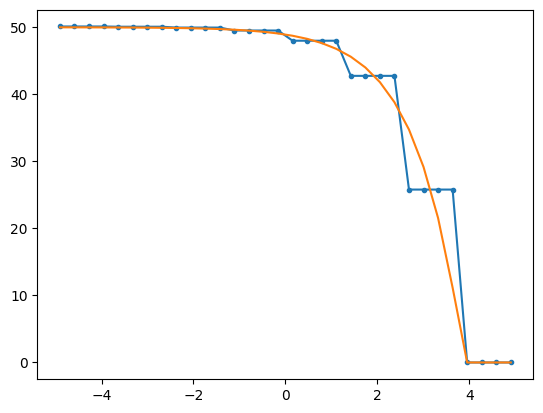

In [16]:
V = instance.solve("QC",n,sigma,T=0, order=False, k=4)
exact = instance.solve("exactp",n,sigma,T=0)
x = instance.x
plt.plot(x,V,'.-')
plt.plot(x,exact)
plt.show()

In [4]:
def Ngates(circuit, args):
    dict_op = qml.specs(circuit)(*args)["resources"].gate_types
    count = 0
    for op,num in dict_op.items():
        # print(op)
        if 'CNOT' in op:
            count+=num
    return count

def L2_rel(a,b):
    return np.linalg.norm(a-b)**2/np.linalg.norm(b)**2

4
5
6
7
8
9


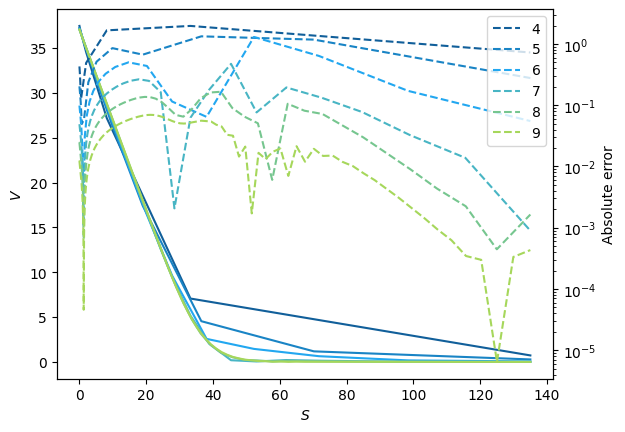

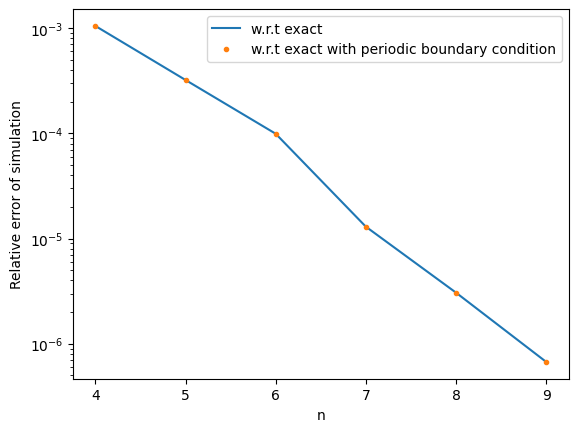

In [5]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
color = ["#115f9a", "#1984c5", "#22a7f0", "#48b5c4", "#76c68f", "#a6d75b", "#c9e52f", "#d0ee11", "#d0f400"]

instance = BS(r,K,Smax)
n_vec = np.arange(4,10)
err_rel = np.zeros((2,len(n_vec)))

for i,n in enumerate(n_vec):
    print(n)
    
    V = instance.solve("QC", n, sigma, T)
    x = instance.x
    exactp = instance.solve("exactp", n, sigma, T)
    exact = instance.solve("exact", n, sigma, T)
    
    err_rel[0,i] = L2_rel(V,exact)
    err_rel[1,i] = L2_rel(V,exactp)
    
    ax1.plot(np.exp(x),V, '-',color=color[i])
    ax2.plot(np.exp(x), np.abs(V-exact), '--',color=color[i])
ax2.set_yscale('log')
ax1.set_ylabel(r"$V$")
ax2.set_ylabel(r"Absolute error")
ax1.set_xlabel(r"$S$")
plt.legend(n_vec, loc='upper right')
plt.show()

plt.plot(n_vec, err_rel[0,:])
plt.plot(n_vec, err_rel[0,:],'.')
plt.yscale('log')
plt.ylabel('Relative error of simulation')
plt.xlabel('n')
plt.legend(['w.r.t exact','w.r.t exact with periodic boundary condition'])
plt.show()

4


/home/hjaunin/.local/lib/python3.9/site-packages/python_tsp/heuristics/simulated_annealing.py:187: RuntimeWarning: divide by zero encountered in scalar divide
  (dfx > 0) and (np.random.rand() <= np.exp(-(fn - fx) / temp))


5
6
7
8


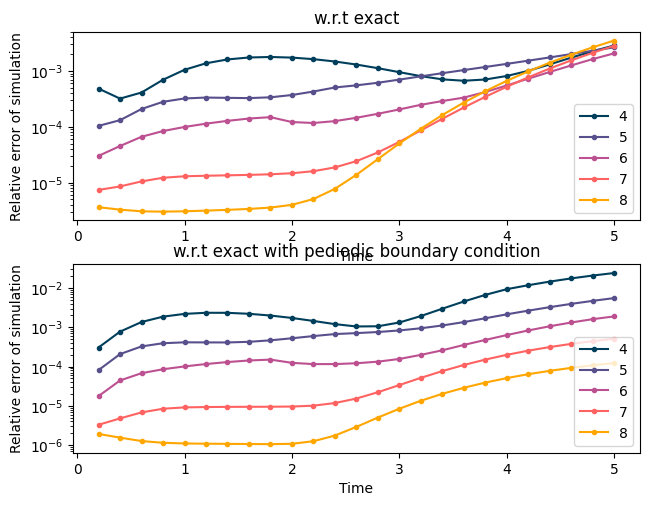

In [6]:
n_vec = np.arange(4,9)

M = 25
t = np.linspace(0,5,M+1)[1:]

fig, ax = plt.subplots(2)
fig.tight_layout()
color = ["#003f5c","#58508d","#bc5090","#ff6361","#ffa600"]

err_rel = np.zeros((M,len(n_vec),2))

for j,n in enumerate(n_vec):
    print(n)
    for i,T in enumerate(t):
        N = 2**n
        
        V = instance.solve("QC", n, sigma, T)
        exact = instance.solve("exact", n, sigma, T)
        exactp = instance.solve("exactp", n, sigma, T, NFourier=100)

        err_rel[i,j,0] = L2_rel(V,exact)
        err_rel[i,j,1] = L2_rel(V,exactp)

    ax[0].plot(t, err_rel[:,j,0],'.-', color=color[j])
    ax[1].plot(t, err_rel[:,j,1],'.-', color=color[j])
for i in range(2):
    ax[i].set_xlabel('Time')
    ax[i].legend(n_vec)
    ax[i].set_ylabel('Relative error of simulation')
    ax[i].set_yscale('log')
ax[0].set_title("w.r.t exact")
ax[1].set_title("w.r.t exact with pediodic boundary condition")
plt.show()

### Optimisation of rotation order

In [7]:
n_vec = np.arange(2,9)
Ncnots = np.zeros((2,len(n_vec)))
depth = np.zeros((2,len(n_vec)))

for i,n in enumerate(n_vec):
    print(n)
    N = 2**n
    
    instance.solve("None", n, sigma, T)
    # c_compile = qml.compile(instance.Circuit)
    c_compile_node = qml.QNode(instance.Circuit, instance.dev)
    coef_H = instance.get_coef_H(T)
    coef_A = instance.get_coef_A(T)
    Ncnots[0,i] = Ngates(c_compile_node,[coef_H, coef_A, n, N//2,N//2, False])
    Ncnots[1,i] = Ngates(c_compile_node,[coef_H, coef_A, n, N//2,N//2, True])
    
    depth[0,i] = qml.specs(c_compile_node)(coef_H, coef_A, n, N//2,N//2, False)["resources"].depth
    depth[1,i] = qml.specs(c_compile_node)(coef_H, coef_A, n, N//2,N//2, True)["resources"].depth
    

2
3
4
5
6
7
8


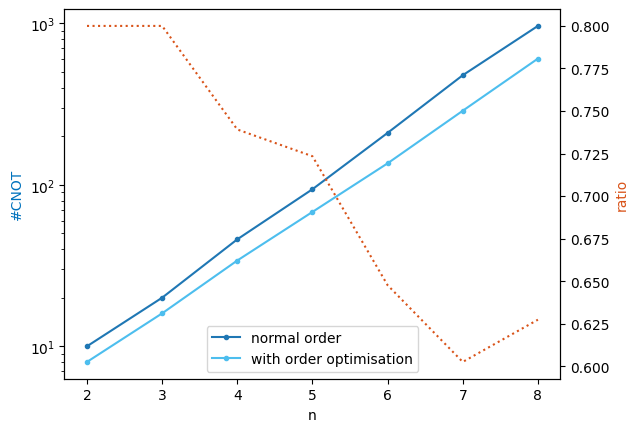

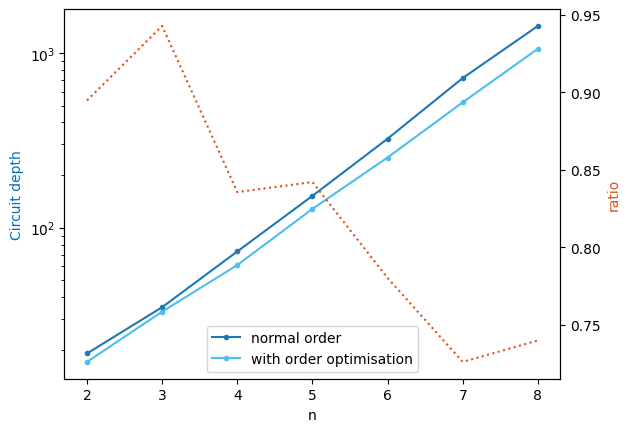

In [8]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(n_vec, Ncnots[0,:],'.-')
ax1.plot(n_vec, Ncnots[1,:],'.-', color=[0.3010, 0.7450, 0.9330])
ax2.plot(n_vec, Ncnots[1,:]/Ncnots[0,:], ':', color=[0.8500, 0.3250, 0.0980])
ax1.set_yscale('log')
ax1.set_ylabel(r'#CNOT', color=[0, 0.4470, 0.7410])
ax2.set_ylabel(r'ratio', color=[0.8500, 0.3250, 0.0980])
ax1.set_xlabel(r'n')
ax1.legend(["normal order","with order optimisation"],loc='lower center')
plt.show()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(n_vec, depth[0,:],'.-')
ax1.plot(n_vec, depth[1,:],'.-', color=[0.3010, 0.7450, 0.9330])
ax2.plot(n_vec, depth[1,:]/depth[0,:], ':', color=[0.8500, 0.3250, 0.0980])
ax1.set_yscale('log')
ax2.set_ylabel(r'ratio', color=[0.8500, 0.3250, 0.0980])
ax1.set_ylabel(r'Circuit depth', color=[0, 0.4470, 0.7410])
ax1.set_xlabel(r'n')
ax1.legend(["normal order","with order optimisation"],loc='lower center')
plt.show()
